In [58]:
#from scipy.sparse.linalg import spsolve
#from scipy.sparse import csc_matrix
#import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [114]:
def generate_fd1D_laplacian(size, w):
    return w*(np.diag(-1*np.ones(size-1),-1) + np.diag(2*np.ones(size),0) + np.diag(-1*np.ones(size-1),1))

def generate_matrices(wA, wB, wC, wD):
    A = generate_fd1D_laplacian(size, wA)
    B = generate_fd1D_laplacian(size, wB)
    C = generate_fd1D_laplacian(size, wC)
    D = generate_fd1D_laplacian(size, wD)
    Z = np.zeros((2*size,2*size))
    Z[:size,:size] = A
    Z[:size,size:] = B
    Z[size:,:size] = C
    Z[size:,size:] = D
    print("determinant of A =", linalg.det(A))
    print("condition number of A =", np.linalg.cond(A))
    print()
    print("determinant of B =", linalg.det(B))
    print("condition number of B =", np.linalg.cond(B))
    print()
    print("determinant of C =", linalg.det(C))
    print("condition number of C =", np.linalg.cond(C))
    print()
    print("determinant of D =", linalg.det(D))
    print("condition number of D =", np.linalg.cond(D))
    print()
    print("determinant of Z =", linalg.det(Z))
    print("condition number of Z =", np.linalg.cond(Z))
    return A, B, C, D, Z

In [115]:
def method_BlockJacobi(nit, L):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    u0 = np.zeros(A.shape[0])
    v0 = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(A + L*np.eye(A.shape[0]), f1 - np.dot(B, v0) + L*u)
        v = linalg.solve(D, f2 - np.dot(C, u0))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
        u0 = u
        v0 = v
    return u, v, np.array(res)

def method_BlockGaussSeidel(nit, L):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(A + L*np.eye(A.shape[0]), f1 - np.dot(B, v) + L*u)
        v = linalg.solve(D, f2 - np.dot(C, u))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

def method_BlockSOR(nit, alpha):
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        delta_u = linalg.solve(A, f1 - np.dot(A, u) - np.dot(B, v))
        u = u + alpha*delta_u
        delta_v = linalg.solve(D, f2 - np.dot(C, u) - np.dot(D, v))
        v = v + delta_v
        #v = v + alpha*delta_v # this affects the choice of alpha
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

def method_ShurPartialJacobi(nit, L):
    DD    = np.diag(D.diagonal(),0)
    invDD = np.diag(1/D.diagonal(),0)
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(
            A  - np.dot(B, np.dot(invDD ,C)) + L*np.eye(A.shape[0]), 
            f1 - np.dot(B, np.dot(invDD, f2 - np.dot(D-DD, v))) + L*u
        )
        v = linalg.solve(D, f2 - np.dot(C,u))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

def method_ShurDualPartialJacobi(nit):
    DD    = np.diag(D.diagonal(),0)
    invDD = np.diag(1/D.diagonal(),0)
    BB    = np.diag(B.diagonal(),0)
    u = np.zeros(A.shape[0])
    v = np.zeros(A.shape[0])
    res = []
    for i in range(nit):
        u = linalg.solve(
            A  - np.dot(BB, np.dot(invDD ,C)), 
            f1 - np.dot(B, np.dot(invDD, f2 - np.dot(D-DD, v))) + np.dot(B-BB,np.dot(invDD,np.dot(C,u)))
        )
        v = linalg.solve(D, f2 - np.dot(C,u))
        res.append(np.linalg.norm(sol - np.concatenate((u,v))))
    return u, v, np.array(res)

In [133]:
size = 10
A, B, C, D, Z = generate_matrices(wA=0.01, wB=0.003, wC=0.001, wD=0.002)
f1 = np.random.rand(size)
f2 = np.random.rand(size)
f = np.concatenate((f1,f2))
sol = linalg.solve(Z, f)
print()
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

determinant of A = 1.1e-19
condition number of A = 48.37415007870815

determinant of B = 6.495389999999997e-25
condition number of B = 48.37415007870816

determinant of C = 1.1000000000000011e-29
condition number of C = 48.374150078708205

determinant of D = 1.1264000000000011e-26
condition number of D = 48.374150078708205

determinant of Z = 2.439352619543289e-46
condition number of Z = 317.00969748289066

monolithic error = 5.87369889011815e-15


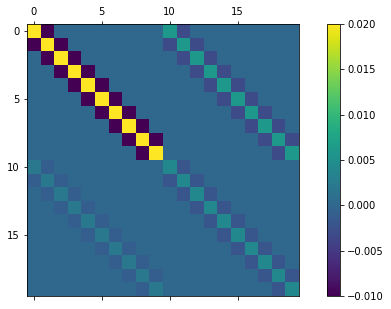

In [134]:
fig1, ax = plt.subplots(1, 1, figsize=(10,5))
cax = ax.matshow(Z)
fig1.colorbar(cax, ax=ax)
plt.savefig('matrix.pdf')
plt.show()

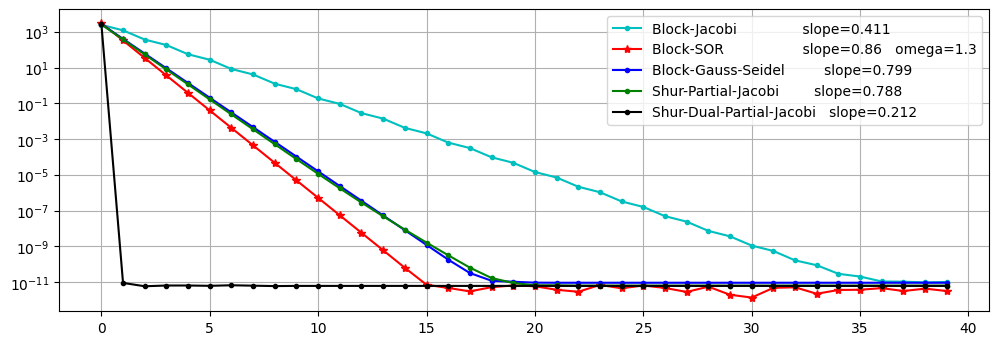

In [135]:
from scipy import stats

def slope(res):
    x = np.arange(len(res))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,np.log10(res))
    return slope

nit = 40
Lvec = [0.4, 0.5]
clrs = ['r', 'b', 'g']

plt.figure(dpi=100, figsize=(12,4))

omega = 1.3
u_BJ,   v_BJ,   res_BJ   = method_BlockJacobi(nit,0)
u_BSOR, v_BSOR, res_BSOR = method_BlockSOR(nit, omega)
u_BGS,  v_BGS,  res_BGS  = method_BlockGaussSeidel(nit, 0)
u_SPJ,  v_SPJ,  res_SPJ  = method_ShurPartialJacobi(nit, 0)
u_SPJ2, v_SPJ2, res_SPJ2 = method_ShurDualPartialJacobi(nit)

nn = 20
l1 = slope(res_BSOR[:nn])
l2 = slope(res_BGS[:nn])
l3 = slope(res_SPJ[:nn])
l4 = slope(res_BJ[:nn])
l5 = slope(res_SPJ2[:nn])

plt.semilogy(res_BJ,  'c.-',  label=f"Block-Jacobi               slope={np.round(-l4,3)}")
plt.semilogy(res_BSOR, 'r*-', label=f"Block-SOR                  slope={np.round(-l1,3)}   omega={omega}")
plt.semilogy(res_BGS, 'b.-',  label=f"Block-Gauss-Seidel         slope={np.round(-l2,3)}   ")
plt.semilogy(res_SPJ, 'g.-',  label=f"Shur-Partial-Jacobi        slope={np.round(-l3,3)}")
plt.semilogy(res_SPJ2,'k.-',  label=f"Shur-Dual-Partial-Jacobi   slope={np.round(-l5,3)}")

plt.grid()
plt.legend()
plt.savefig('conv.pdf')
plt.show()